### A notebook for iterating on plots

Compare shotdata_raw, shotdata_filtered/garpos_raw, garpos_unflagged


Requires you to have already run garpos processing and have results locally.

In [6]:
#imports
from es_sfgtools.data_mgmt.ingestion.archive_pull import load_site_metadata
from es_sfgtools.workflows.workflow_handler import WorkflowHandler
from es_sfgtools.config.env_config import Environment
import pandas as pd
from datetime import datetime, timezone, UTC

from es_sfgtools.workflows.modeling.garpos_handler import GarposHandler

In [7]:
workdir = "/Users/mikegottlieb/data/"

# set network/station/campaign and get metadata
NETWORK = "cascadia-gorda"
STATION = "NCC1"
CAMPAIGN_NAME = "2025_A_1126"

metadata = load_site_metadata(NETWORK, STATION)
# print surveys for campaign from metadata
print("Surveys for campaign:", CAMPAIGN_NAME)
for campaign in metadata.campaigns:
    if campaign.name == CAMPAIGN_NAME:
        for survey in campaign.surveys:
            print("  ", survey.id, survey.start, survey.end)


Loading site metadata from https://data.earthscope.org/archive/seafloor/metadata/cascadia-gorda/NCC1.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1126.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1126.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1063.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1065.json


Surveys for campaign: 2025_A_1126
   2025_A_1126_1 2025-09-07 20:27:00 2025-09-08 13:40:00
   2025_A_1126_2 2025-09-08 13:40:00 2025-09-12 19:33:00
   2025_A_1126_3 2025-09-12 19:33:00 2025-09-13 07:12:00


In [13]:
S3_SYNC_BUCKET = "seafloor-public-bucket-bucket83908e77-6ial2vrmrawf"
workflow_handler = WorkflowHandler(directory=workdir)
workflow_handler.set_network_station_campaign(
    network_id=NETWORK,
    station_id=STATION,
    campaign_id=CAMPAIGN_NAME
)
garpos_handler = workflow_handler.modeling_get_garpos_handler()
garpos_handler.set_network_station_campaign(
    network_id=NETWORK,
    station_id=STATION,
    campaign_id=CAMPAIGN_NAME
)
SURVEY_NUMBER = 2
SURVEY_ID=f"{CAMPAIGN_NAME}_{SURVEY_NUMBER}"
garpos_handler.set_survey(SURVEY_ID)


/Users/mikegottlieb/GIT/es_sfgtools/src/es_sfgtools/workflows/workflow_handler.py:76: UserWarning: Environment variable S3_SYNC_BUCKET is not set.
  Environment.load_working_environment()
Creating TileDB arrays for NCC1
Consolidating existing TileDB arrays for NCC1
Changed working station to cascadia-gorda NCC1 2025_A_1126


Using data file /Users/mikegottlieb/data/cascadia-gorda/NCC1/2025_A_1126/2025_A_1126_2/GARPOS/results/run_1/NCC1.2025_A_1126_0-res.dat for plotting.
Index(['Unnamed: 0.1', 'Unnamed: 0', 'SET', 'LN', 'MT', 'TT', 'ResiTT',
       'TakeOff', 'gamma', 'flag', 'ST', 'ant_e0', 'ant_n0', 'ant_u0', 'head0',
       'pitch0', 'roll0', 'RT', 'ant_e1', 'ant_n1', 'ant_u1', 'head1',
       'pitch1', 'roll1', 'dV0', 'gradV1e', 'gradV1n', 'gradV2e', 'gradV2n',
       'dV', 'LogResidual', 'ResiRange', 'dVO', 'time'],
      dtype='object')


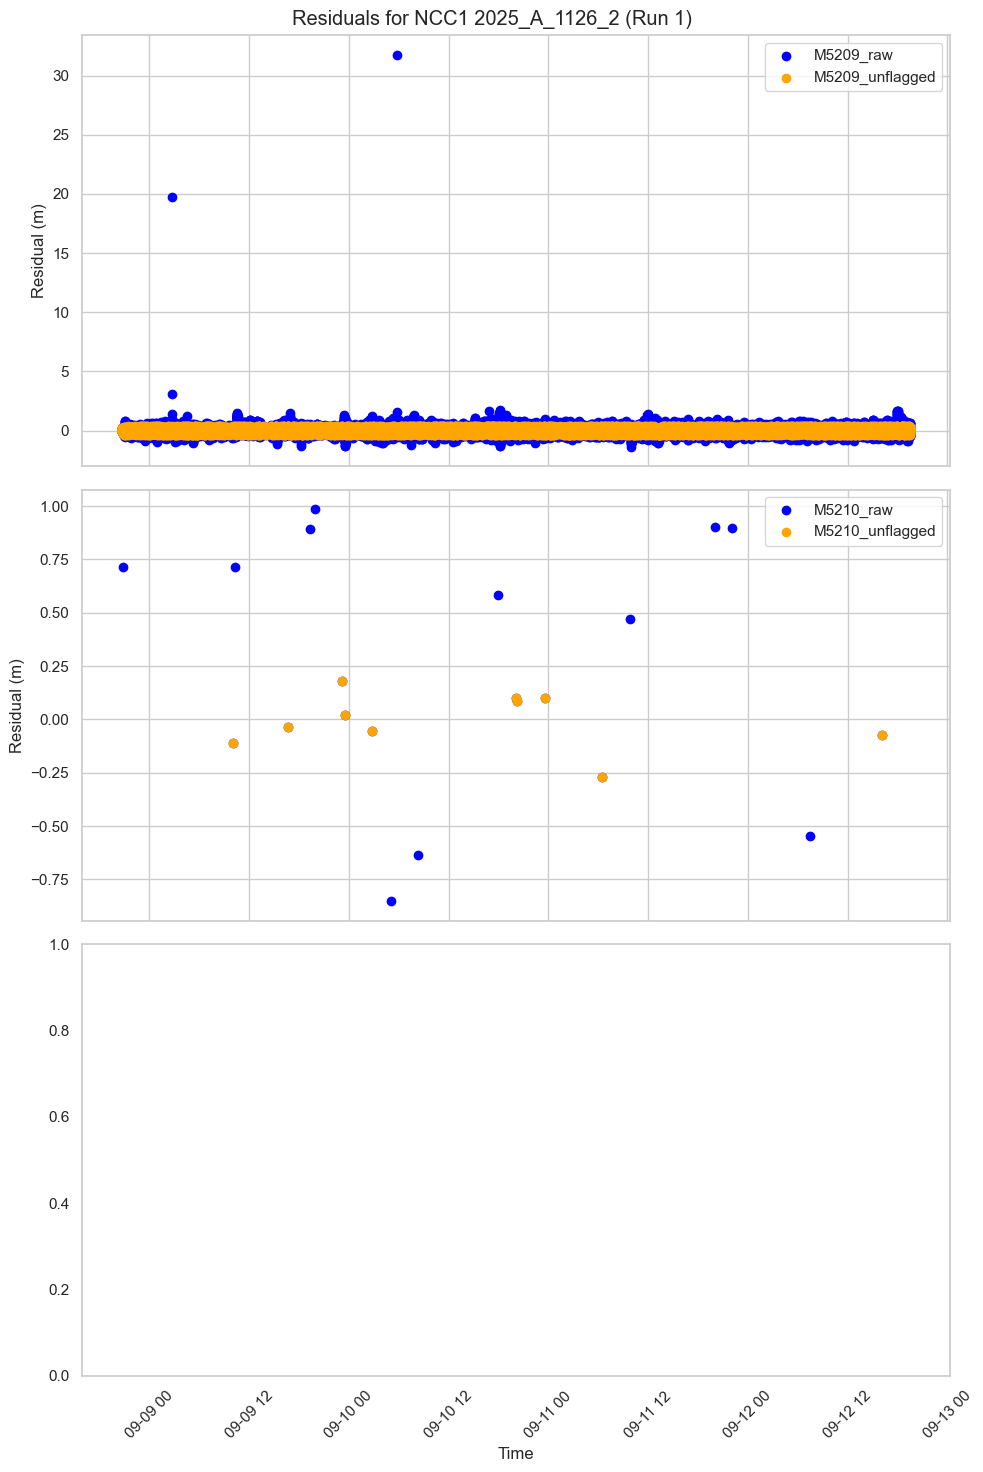

In [14]:
# plot the residuals only on 3 subplots
garpos_handler._plot_residuals(survey_id=SURVEY_ID, run_id=1)


In [15]:
#plot metadata vs actual shot data time windows

#read shot data dfs from disk
def read_shotdata_file(filepath):
    return pd.read_csv(filepath, sep=",", header=0, index_col=0)

#make a plot showing the metadata and shotdata time windows from multiple surveys on the same plot
#make the lines thicker and add markers

def plot_shotdata_time_windows(station_name, metadata_time_windows, shotdata_time_windows):
    import matplotlib.pyplot as plt
    colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    plt.figure(figsize=(10, 5))
    # use barh to plot windows
    #only show legend for first survey
    for i, survey_name in enumerate(metadata_time_windows.keys()):
        plt.barh(i-.1, metadata_time_windows[survey_name][1] - metadata_time_windows[survey_name][0], left=metadata_time_windows[survey_name][0], color=colors[0], label='Metadata' if i == 0 else "", height=0.2)
        plt.barh(i + 0.1, shotdata_time_windows[survey_name][1] - shotdata_time_windows[survey_name][0], left=shotdata_time_windows[survey_name][0], color=colors[1], label='Shotdata' if i == 0 else "", height=0.2)
    plt.ylim(-0.5, len(metadata_time_windows))
    plt.yticks(range(len(metadata_time_windows)), list(metadata_time_windows.keys()))
    plt.title(f"Survey Time Windows for Station {station_name}")
    plt.legend()
    plt.show()



2025_A_1126_1
  Metadata Start: 2025-09-07 20:27:00,       End: 2025-09-08 13:40:00
  Shotdata Start: 2025-09-07 20:27:00+00:00, End: 2025-09-08 10:08:37+00:00
2025_A_1126_2
  Metadata Start: 2025-09-08 13:40:00,       End: 2025-09-12 19:33:00
  Shotdata Start: 2025-09-08 13:40:08+00:00, End: 2025-09-12 16:06:20+00:00
2025_A_1126_3
  Metadata Start: 2025-09-12 19:33:00,       End: 2025-09-13 07:12:00
  Shotdata Start: 2025-09-12 19:33:06+00:00, End: 2025-09-13 06:49:15+00:00


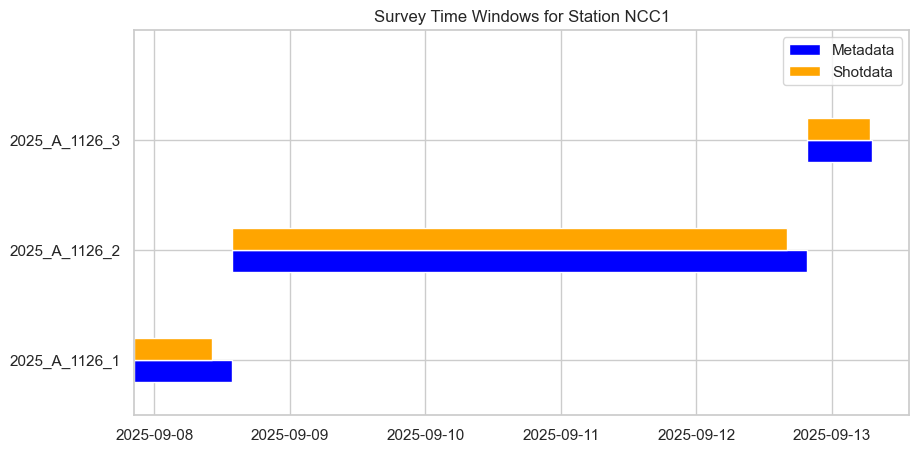

In [16]:
metadata_surveys = []
for campaign in metadata.campaigns:
    if campaign.name == CAMPAIGN_NAME:
        metadata_surveys = campaign.surveys

metadata_time_windows = {}
shotdata_time_windows = {}
shotdata_dfs = {}
for survey_name in sorted(garpos_handler.current_campaign_dir.surveys):
    if survey_name in [survey.id for survey in metadata_surveys]:
        print(f"{survey_name}")
        
        for survey in metadata_surveys:
            if survey.id == survey_name:
                print(f"  Metadata Start: {survey.start},       End: {survey.end}")
                metadata_start = survey.start.replace(tzinfo=UTC)
                metadata_end = survey.end.replace(tzinfo=UTC)
                metadata_time_windows[survey_name] = (metadata_start, metadata_end)
            continue
        try:
            shotdata_filepath = garpos_handler.current_campaign_dir.surveys[survey_name].shotdata
            shotdata_df = read_shotdata_file(shotdata_filepath)
            shotdata_dfs[survey_name] = shotdata_df
            #use utc
            start = datetime.fromtimestamp(shotdata_df['pingTime'].iloc[0], tz=timezone.utc)
            end = datetime.fromtimestamp(shotdata_df['pingTime'].iloc[-1], tz=timezone.utc)
            print(f"  Shotdata Start: {start}, End: {end}")

            shotdata_time_windows[survey_name] = (start, end)
            
        except Exception as e:
            print(e)

plot_shotdata_time_windows(STATION, metadata_time_windows, shotdata_time_windows)

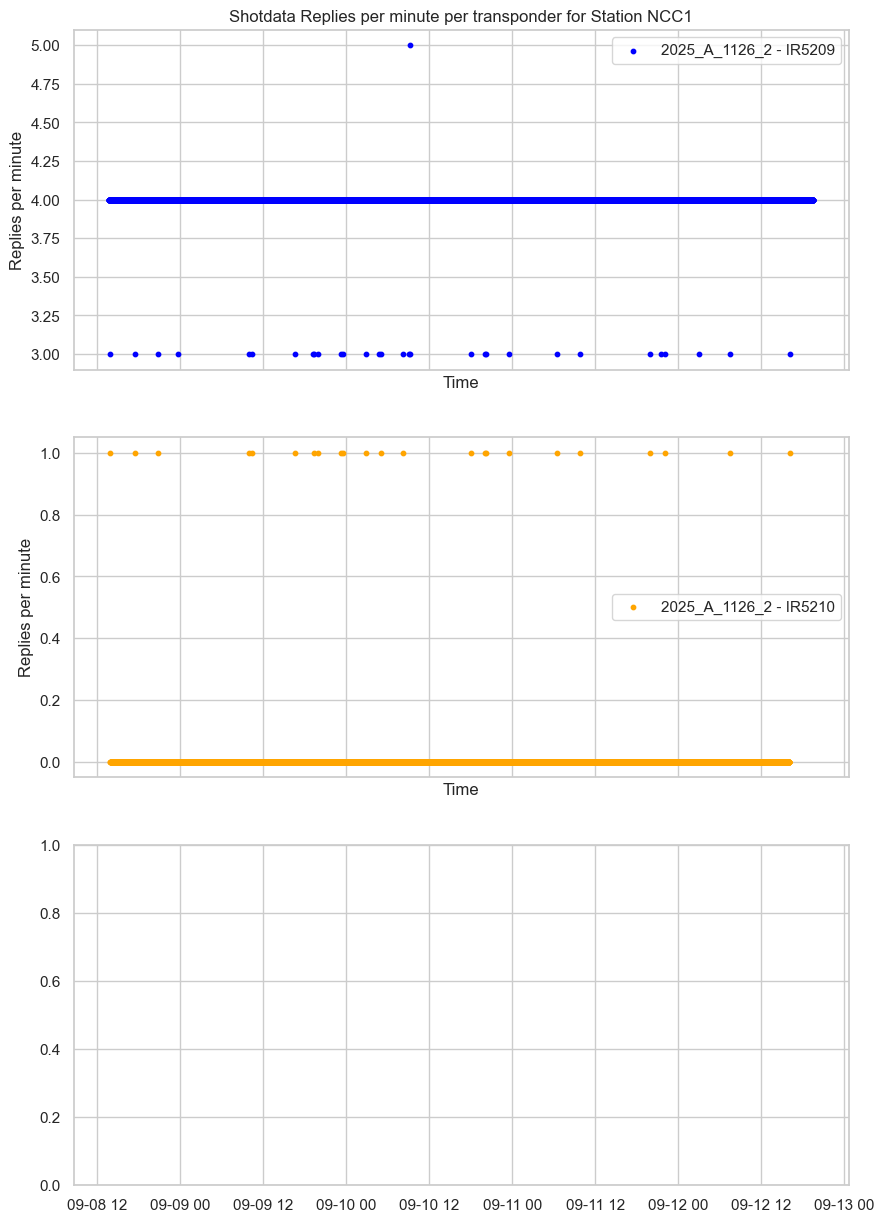

In [18]:
# plot shotdata replies per transponder per minute.  complete data should be 4 replies for each transponder

def plot_shotdata_replies(station_name, shotdata_dfs):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
    colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for survey_name, shotdata_df in shotdata_dfs.items():
        if survey_name == '2025_A_1126_2':
            unique_ids = shotdata_df["transponderID"].unique()
            for i, transponder_id in enumerate(unique_ids):
                df = shotdata_df[shotdata_df["transponderID"] == transponder_id]
                # # Resample the data to 1 minute intervals and count replies
                df = df.set_index(pd.to_datetime(df['pingTime'], unit='s'))
            #print(df)
                replies_per_minute = df['pingTime'].resample('min').count()
                axs[i].scatter(replies_per_minute.index, replies_per_minute.values, label=f"{survey_name} - {transponder_id}", s=10, color=colors[i % len(colors)])
                
                axs[i].set_xlabel("Time")
                axs[i].set_ylabel("Replies per minute")
                axs[i].legend()
        # print(replies_per_minute)
        # plt.scatter(replies_per_minute.index, replies_per_minute.values, label=survey_name)

    axs[0].set_title(f"Shotdata Replies per minute per transponder for Station {station_name}")
    
    plt.show()

plot_shotdata_replies(STATION, shotdata_dfs)